<a href="https://colab.research.google.com/github/yaswanthrajeev/CN-LAB/blob/main/maeketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

print("Imports done.")


Imports done.


In [4]:
#  load data
path = 'sample_data/MMM Weekly.csv'
df = pd.read_csv(path)
df['week'] = pd.to_datetime(df['week'])
df = df.sort_values('week').reset_index(drop=True)

print("Rows, cols:", df.shape)
print("\nColumns:", df.columns.tolist())
display(df.head())
display(df.describe().T)


Rows, cols: (104, 12)

Columns: ['week', 'facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend', 'social_followers', 'average_price', 'promotions', 'emails_send', 'sms_send', 'revenue']


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95


,count,mean,min,25%,50%,75%,max,std
week,104,2024-09-11 12:00:00,2023-09-17 00:00:00,2024-03-15 06:00:00,2024-09-11 12:00:00,2025-03-10 18:00:00,2025-09-07 00:00:00,NaN
facebook_spend,104.0,5346.3025,2456.94,4538.9775,5293.78,6033.325,9325.18,1168.961177
google_spend,104.0,1543.866442,0.0,0.0,0.0,3374.205,6083.16,1863.350279
tiktok_spend,104.0,955.632212,0.0,0.0,0.0,2487.1725,4143.25,1376.993132
instagram_spend,104.0,1019.342885,0.0,0.0,0.0,2395.35,3877.99,1349.18425
snapchat_spend,104.0,747.465,0.0,0.0,0.0,1705.8725,3126.04,982.088273
social_followers,104.0,72414.509615,0.0,38318.25,81109.5,110281.25,143477.0,47778.448985
average_price,104.0,99.9625,87.56,94.2075,99.49,105.395,113.38,6.496186
promotions,104.0,0.211538,0.0,0.0,0.0,0.0,1.0,0.410377
emails_send,104.0,120691.067308,68655.0,102971.5,120237.0,136594.0,185460.0,25158.181476


In [5]:
#  basic cleaning & zero-spend flags
# ensure weekly frequency (creates NaNs if weeks missing)
df = df.set_index('week').asfreq('W').reset_index()

# numeric columns auto-detected
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# small interpolation for short missing runs (limit=2 weeks)
df[num_cols] = df[num_cols].interpolate(limit=2).ffill().bfill()

# create zero-spend flags for channels (helps model detect structural zero weeks)
channels = ['facebook_spend','tiktok_spend','instagram_spend','snapchat_spend','google_spend']
for ch in channels:
    if ch in df.columns:
        df[f'{ch}_zero'] = (df[ch] == 0).astype(int)

print("After cleaning:", df.shape)
display(df.head())


After cleaning: (104, 17)


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue,facebook_spend_zero,tiktok_spend_zero,instagram_spend_zero,snapchat_spend_zero,google_spend_zero
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16,0,0,0,0,0
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02,0,1,1,1,0
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01,0,1,1,1,1
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78,0,1,1,1,1
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95,0,1,0,1,1


In [6]:
# feature engineering
# Week-of-year indicator (seasonality proxy)
df['weekofyear'] = df['week'].dt.isocalendar().week
df['year'] = df['week'].dt.year

# lags for revenue & channels
lags = [1,2,4]
for col in ['revenue'] + channels:
    if col in df.columns:
        for l in lags:
            df[f'{col}_lag{l}'] = df[col].shift(l)

# rolling means
for col in channels + ['revenue']:
    if col in df.columns:
        df[f'{col}_roll4'] = df[col].rolling(window=4, min_periods=1).mean()

# log transforms (stabilize skew) - create but model will use original scaled
for col in ['revenue'] + channels:
    if col in df.columns:
        df[f'log_{col}'] = np.log(df[col].clip(lower=0.01))

# Ensure promotions numeric
if 'promotions' in df.columns:
    df['promotions'] = pd.to_numeric(df['promotions'], errors='coerce').fillna(0)

# drop initial rows with NaNs from lagging
df = df.dropna().reset_index(drop=True)
print("After feature engineering rows:", df.shape[0])
display(df.filter(regex='lag|roll4|log_').head())


After feature engineering rows: 100


,revenue_lag1,revenue_lag2,revenue_lag4,facebook_spend_lag1,facebook_spend_lag2,facebook_spend_lag4,tiktok_spend_lag1,tiktok_spend_lag2,tiktok_spend_lag4,instagram_spend_lag1,...,instagram_spend_roll4,snapchat_spend_roll4,google_spend_roll4,revenue_roll4,log_revenue,log_facebook_spend,log_tiktok_spend,log_instagram_spend,log_snapchat_spend,log_google_spend
0,452.78,513.01,83124.16,7167.16,5893.00,6030.80,0.0,0.0,2993.22,0.00,...,809.2875,0.0000,676.0000,10695.1900,10.632049,8.586773,-4.60517,8.082449,-4.605170,-4.605170
1,41441.95,452.78,373.02,5360.29,7167.16,5241.44,0.0,0.0,0.00,3237.15,...,1668.9600,0.0000,846.4725,46037.6075,11.861769,8.341718,-4.60517,8.142846,-4.605170,8.127372
2,141742.69,41441.95,513.01,4195.29,5360.29,5893.00,0.0,0.0,0.00,3438.69,...,2444.9075,209.6875,1849.6700,56651.4575,10.668220,8.473960,-4.60517,8.040379,6.731913,8.297242
3,42968.41,141742.69,452.78,4788.44,4195.29,7167.16,0.0,0.0,0.00,3103.79,...,3157.9325,767.2025,1849.6700,56538.5125,0.000000,8.833766,-4.60517,7.955811,7.709784,-4.605170
4,1.00,42968.41,41441.95,6862.08,4788.44,5360.29,0.0,0.0,0.00,2852.10,...,3099.5850,1166.8275,1849.6700,51957.3325,10.048334,8.664385,-4.60517,8.007620,7.376821,-4.605170


In [7]:
#  define features and splits
TARGET = 'revenue'
MEDIATOR = 'google_spend'

# socials and control variables present in your file
socials = [c for c in ['facebook_spend','tiktok_spend','instagram_spend','snapchat_spend'] if c in df.columns]
controls = [c for c in ['average_price','promotions','emails_send','sms_send','social_followers'] if c in df.columns]

# mediator features: socials + controls + lagged socials if available
med_feats = socials + [f'{s}_lag1' for s in socials if f'{s}_lag1' in df.columns] + controls

# revenue features: pred_google (placeholder) + socials + controls + revenue_lag1
rev_feats = ['pred_google'] + socials + controls
if 'revenue_lag1' in df.columns:
    rev_feats.append('revenue_lag1')
rev_feats += [c for c in df.columns if c.endswith('_zero')]  # include zero flags

# Time-based train/test: last 16 weeks as test or 20% whichever smaller
n = len(df)
test_weeks = min(16, max(8, int(0.2*n)))  # at least 8-week test if possible
train_idx = df.index[:-test_weeks]
test_idx = df.index[-test_weeks:]

print("n rows:", n, "train:", len(train_idx), "test:", len(test_idx))
print("mediator features:", med_feats)
print("revenue features (example):", rev_feats)


n rows: 100 train: 84 test: 16
mediator features: ['facebook_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend', 'facebook_spend_lag1', 'tiktok_spend_lag1', 'instagram_spend_lag1', 'snapchat_spend_lag1', 'average_price', 'promotions', 'emails_send', 'sms_send', 'social_followers']
revenue features (example): ['pred_google', 'facebook_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend', 'average_price', 'promotions', 'emails_send', 'sms_send', 'social_followers', 'revenue_lag1', 'facebook_spend_zero', 'tiktok_spend_zero', 'instagram_spend_zero', 'snapchat_spend_zero', 'google_spend_zero']


In [8]:
# Stage 1 mediator models (RidgeCV and LassoCV)
X_med = df.loc[train_idx, med_feats]
y_med = df.loc[train_idx, MEDIATOR]

# Standard scaler + CV is not inside RidgeCV/LassoCV, so scale explicitly
scaler_med = StandardScaler()
X_med_s = scaler_med.fit_transform(X_med)

# RidgeCV with built-in alphas; LassoCV for sparsity
ridge_cv = RidgeCV(alphas=[0.01,0.1,1.0,10.0], scoring='neg_mean_squared_error', cv=5)
lasso_cv = LassoCV(alphas=[0.001,0.01,0.1,1.0], cv=5, max_iter=5000)

ridge_cv.fit(X_med_s, y_med)
lasso_cv.fit(X_med_s, y_med)

print("Ridge mediator alpha:", ridge_cv.alpha_)
print("Lasso mediator alpha (cv):", lasso_cv.alpha_)

# Save scalers and models to reuse
joblib.dump(scaler_med, 'scaler_med.joblib')
joblib.dump(ridge_cv, 'ridge_med.joblib')
joblib.dump(lasso_cv, 'lasso_med.joblib')

# Predict google for entire dataset using Ridge (primary)
X_med_all = scaler_med.transform(df[med_feats])
df['pred_google_ridge'] = ridge_cv.predict(X_med_all)
df['pred_google_lasso'] = lasso_cv.predict(X_med_all)

display(df[['week','google_spend','pred_google_ridge','pred_google_lasso']].tail())


Ridge mediator alpha: 10.0
Lasso mediator alpha (cv): 1.0


,week,google_spend,pred_google_ridge,pred_google_lasso
95,2025-08-10,0.0,2442.868456,2527.041457
96,2025-08-17,0.0,1143.772043,1104.053513
97,2025-08-24,0.0,3354.204721,3738.008658
98,2025-08-31,0.0,1934.435799,1879.843476
99,2025-09-07,0.0,1767.910172,1758.299618


In [10]:
#  Stage 2 regressions (Ridge & Lasso) using predicted google from Ridge
df2 = df.copy()
df2['pred_google'] = df2['pred_google_ridge']  # choose ridge-predicted Google as primary

# Build X and y for train and test
X_rev = df2[rev_feats].fillna(0)
y_rev = df2[TARGET]

X_train = X_rev.iloc[train_idx]
y_train = y_rev.iloc[train_idx]
X_test = X_rev.iloc[test_idx]
y_test = y_rev.iloc[test_idx]

# scale features
scaler_rev = StandardScaler()
X_train_s = scaler_rev.fit_transform(X_train)
X_test_s = scaler_rev.transform(X_test)

# RidgeCV and LassoCV for revenue
ridge_rev = RidgeCV(alphas=[0.01,0.1,1.0,10.0], scoring='neg_mean_squared_error', cv=5)
lasso_rev = LassoCV(alphas=[0.001,0.01,0.1,1.0], cv=5, max_iter=5000)

ridge_rev.fit(X_train_s, y_train)
lasso_rev.fit(X_train_s, y_train)

# Predictions & metrics
def metrics(y_true, y_pred):
    return {
        'RMSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

yhat_ridge = ridge_rev.predict(X_test_s)
yhat_lasso = lasso_rev.predict(X_test_s)

print("Ridge revenue alpha:", ridge_rev.alpha_)
print("Ridge test metrics:", metrics(y_test, yhat_ridge))
print("Lasso test metrics:", metrics(y_test, yhat_lasso))

# Save models + scaler
joblib.dump(scaler_rev, 'scaler_rev.joblib')
joblib.dump(ridge_rev, 'ridge_rev.joblib')
joblib.dump(lasso_rev, 'lasso_rev.joblib')


Ridge revenue alpha: 10.0
Ridge test metrics: {'RMSE': 5562631780.228554, 'MAE': 67761.86987053108, 'R2': -0.5679174529567321}
Lasso test metrics: {'RMSE': 7781442993.33618, 'MAE': 78225.50205397699, 'R2': -1.1933251670198417}


['lasso_rev.joblib']

In [11]:
#  XGBoost model (uses raw features without scaling)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42
}
# simple grid + early stopping (train on train, validate on test)
best_bst = None
best_rmse = 1e9
for eta in [0.05, 0.1]:
    for max_depth in [3,5]:
        p = params.copy()
        p.update({'eta': eta, 'max_depth': max_depth})
        bst = xgb.train(p, dtrain, num_boost_round=500, evals=[(dtest,'val')], early_stopping_rounds=25, verbose_eval=False)
        preds = bst.predict(dtest)
        rmse = mean_squared_error(y_test, preds)
        if rmse < best_rmse:
            best_rmse = rmse
            best_bst = bst

xgb_preds = best_bst.predict(dtest)
print("XGBoost test metrics:", metrics(y_test, xgb_preds))
# save model
best_bst.save_model('xgb_revenue.model')


XGBoost test metrics: {'RMSE': 967055927.2266874, 'MAE': 19645.142255859377, 'R2': 0.7274196951749916}


,model,RMSE,MAE,R2
2,XGBoost,9.670559e+08,19645.142256,0.727420
0,Ridge_rev,5.562632e+09,67761.869871,-0.567917
1,Lasso_rev,7.781443e+09,78225.502054,-1.193325


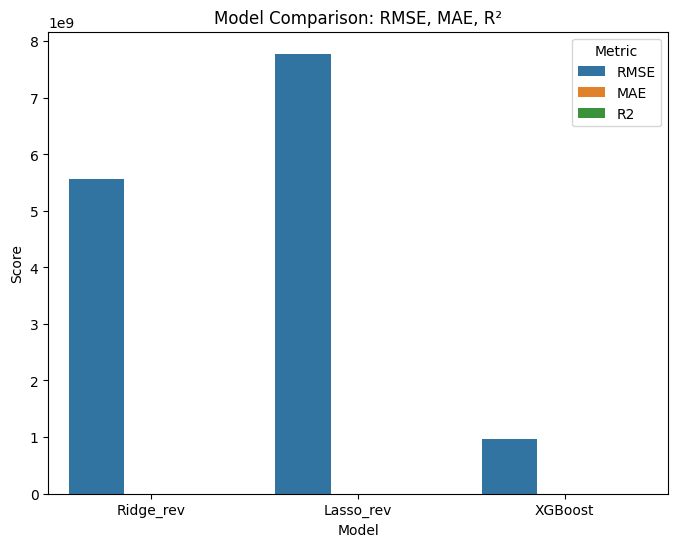

In [16]:
#  summary comparison
results = {
    'model': ['Ridge_rev', 'Lasso_rev', 'XGBoost'],
    'RMSE': [],
    'MAE': [],
    'R2': []
}
for name, preds in [('Ridge_rev', yhat_ridge), ('Lasso_rev', yhat_lasso), ('XGBoost', xgb_preds)]:
    m = metrics(y_test, preds)
    results['RMSE'].append(m['RMSE'])
    results['MAE'].append(m['MAE'])
    results['R2'].append(m['R2'])

comp_df = pd.DataFrame(results)
display(comp_df.sort_values('RMSE'))

comp_df_melted = comp_df.melt(id_vars='model', var_name='Metric', value_name='Value')

plt.figure(figsize=(8,6))
sns.barplot(data=comp_df_melted, x='model', y='Value', hue='Metric')
plt.title('Model Comparison: RMSE, MAE, R²')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric')
plt.show()


,0
instagram_spend,41072.094396
average_price,-29548.282450
sms_send,22800.668552
instagram_spend_zero,-20921.528568
pred_google,18772.255506
revenue_lag1,11612.488667
snapchat_spend,-9848.615072
google_spend_zero,9744.272226
promotions,8769.657978
social_followers,6943.417609


,0
average_price,4.332146e+10
instagram_spend,3.888807e+10
sms_send,5.247666e+09
revenue_lag1,2.858619e+09
facebook_spend,7.857340e+08
pred_google,4.528109e+08
google_spend_zero,2.632728e+08


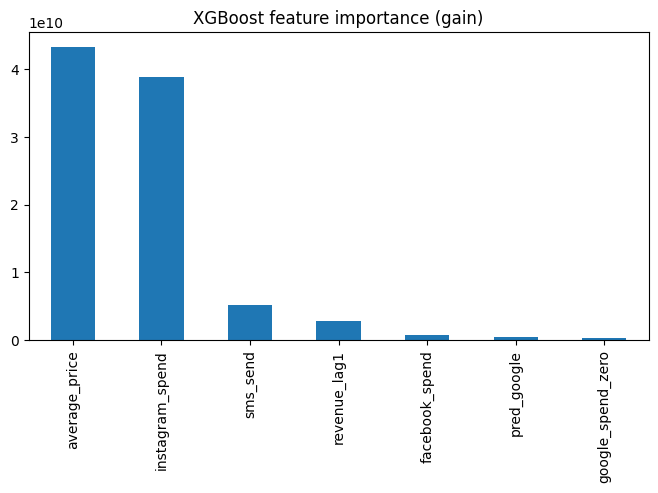

In [17]:
#  coefficients (Ridge) and XGBoost importance plot
# Coefficients are on scaled features: show sign + relative magnitude
coef = pd.Series(ridge_rev.coef_, index=X_train.columns).sort_values(key=abs, ascending=False)
display(coef.head(20))

# XGBoost feature importance
fi = best_bst.get_score(importance_type='gain')
fi_series = pd.Series(fi).sort_values(ascending=False)
display(fi_series.head(20))

# simple bar plot for feature importance
plt.figure(figsize=(8,4))
fi_series.head(10).plot.bar()
plt.title('XGBoost feature importance (gain)')
plt.show()


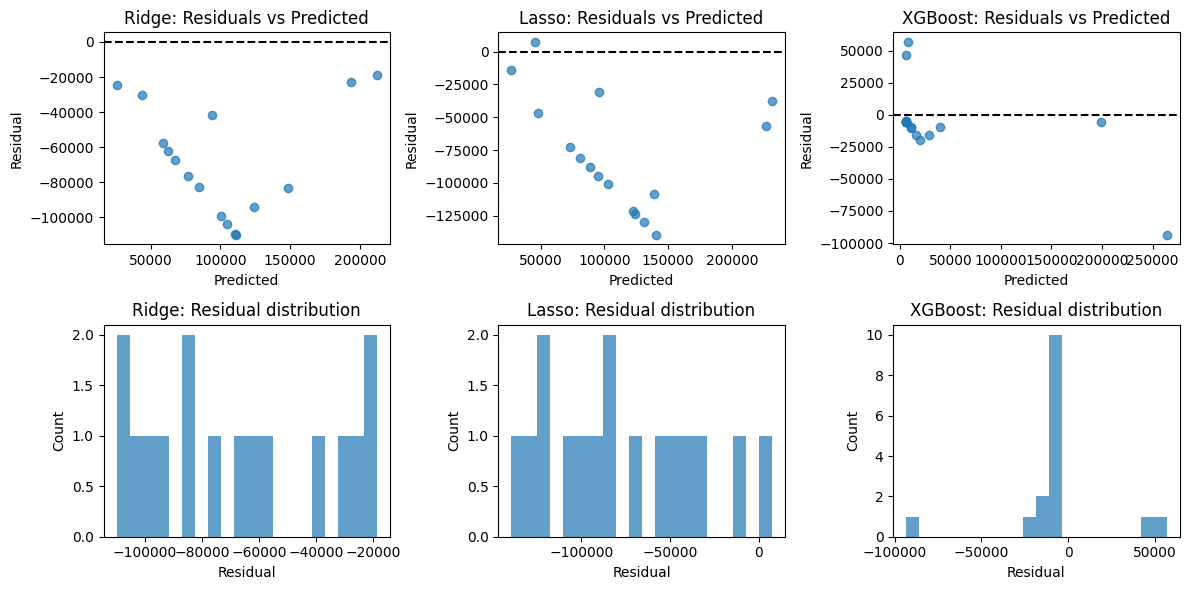

In [32]:
# Combine predictions into a dictionary
preds_dict = {
    'Ridge': yhat_ridge,
    'Lasso': yhat_lasso,
    'XGBoost': xgb_preds
}

plt.figure(figsize=(12,6))

for i, (name, preds) in enumerate(preds_dict.items(), 1):
    resids = y_test - preds

    # Scatter plot of residuals vs predicted
    plt.subplot(2, 3, i)
    plt.scatter(preds, resids, alpha=0.7)
    plt.axhline(0, linestyle='--', color='k')
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.title(f'{name}: Residuals vs Predicted')

    # Histogram of residuals
    plt.subplot(2, 3, i+3)
    plt.hist(resids, bins=20, alpha=0.7)
    plt.xlabel('Residual')
    plt.ylabel('Count')
    plt.title(f'{name}: Residual distribution')

plt.tight_layout()
plt.show()


In [20]:
#  rolling growing-window evaluation to check stability (blocks of 4 weeks)
def rolling_eval(X, y, start_frac=0.5, step=4):
    n = len(X)
    start = int(n * start_frac)
    rmses = []
    for s in range(start, n, step):
        train_X = X.iloc[:s]
        train_y = y.iloc[:s]
        test_X = X.iloc[s:s+step]
        test_y = y.iloc[s:s+step]
        if len(test_X) < 1:
            break
        model = Ridge(alpha=ridge_rev.alpha_)
        model.fit(train_X, train_y)
        pred = model.predict(test_X)
        rmses.append(mean_squared_error(test_y, pred))
    return rmses

rmses = rolling_eval(X_rev, y_rev, start_frac=0.5, step=4)
print("Rolling RMSE blocks:", rmses)
print("Mean / Std:", np.mean(rmses), np.std(rmses))


Rolling RMSE blocks: [1846112868.2719274, 914916120.9090526, 527268121.194568, 3966111267.6125393, 2441334335.4989777, 4668615729.4200735, 1768972266.4906235, 2108354929.1010141, 4721218423.664442, 6076425265.286488, 6856166104.955973, 2155330038.257716, 4049231474.531495]
Mean / Std: 3238465918.861145 1891392417.8741767


,price,promotions,pred_rev
0,84.28500,0,161201.080783
1,84.28500,1,169456.753459
2,86.62625,0,147083.323963
3,86.62625,1,155338.996640
4,88.96750,0,132965.567144
5,88.96750,1,141221.239820
6,91.30875,0,118847.810324
7,91.30875,1,127103.483001
8,93.65000,0,104730.053505
9,93.65000,1,112985.726181


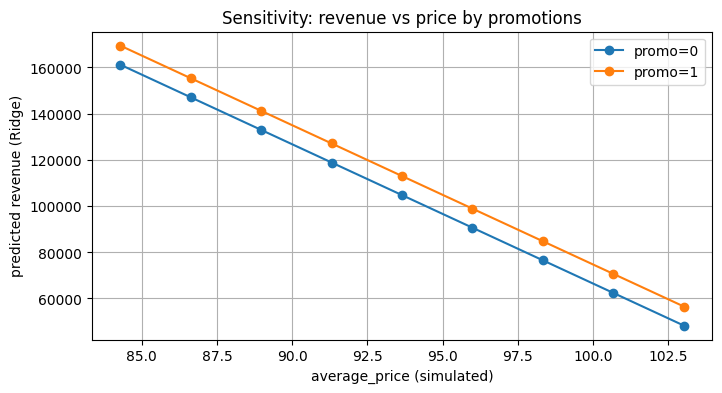

In [22]:
#  sensitivity analysis starting from the last available week
# Correctly select the last row including lagged features for the mediator model
baseline_med_in = df.iloc[-1:].copy()  # Use the original df to get lagged features
baseline_rev_in = X_rev.iloc[-1:].copy() # Use X_rev for revenue features

price_vals = np.linspace(0.9*baseline_rev_in['average_price'].values[0], 1.1*baseline_rev_in['average_price'].values[0], 9) if 'average_price' in baseline_rev_in.columns else [None]
promo_vals = [0,1] if 'promotions' in baseline_rev_in.columns else [0]

sims = []
for p in price_vals:
    for promo in promo_vals:
        # Create a row for the mediator model input
        row_med_in = baseline_med_in.copy()
        if p is not None and 'average_price' in row_med_in.columns:
             row_med_in['average_price'] = p
        if 'promotions' in row_med_in.columns:
             row_med_in['promotions'] = promo

        # Recompute pred_google via mediator model (use scaler_med + ridge_cv)
        # Ensure med_in has the same columns as X_med used for training
        med_in_s = scaler_med.transform(row_med_in[med_feats])
        pred_google_val = ridge_cv.predict(med_in_s)[0]

        # Create a row for the revenue model input
        row_rev_in = baseline_rev_in.copy()
        if p is not None and 'average_price' in row_rev_in.columns:
             row_rev_in['average_price'] = p
        if 'promotions' in row_rev_in.columns:
             row_rev_in['promotions'] = promo

        row_rev_in['pred_google'] = pred_google_val # add the predicted google

        # Predict revenue with Ridge (scaled)
        # Ensure row_rev_in has the same columns as X_train used for training
        row_s = scaler_rev.transform(row_rev_in[rev_feats].fillna(0)) # Fill NaNs for consistency
        pred_rev = ridge_rev.predict(row_s)[0]

        sims.append({'price': p, 'promotions': promo, 'pred_rev': pred_rev})

sim_df = pd.DataFrame(sims)
display(sim_df)
# plot
if 'price' in sim_df.columns and sim_df['price'].notna().any():
    plt.figure(figsize=(8,4))
    for promo in sim_df['promotions'].unique():
        subset = sim_df[sim_df['promotions']==promo]
        plt.plot(subset['price'], subset['pred_rev'], marker='o', label=f'promo={promo}')
    plt.xlabel('average_price (simulated)')
    plt.ylabel('predicted revenue (Ridge)')
    plt.title('Sensitivity: revenue vs price by promotions')
    plt.legend()
    plt.grid(True)
    plt.show()

Best model based on RMSE: XGBoost


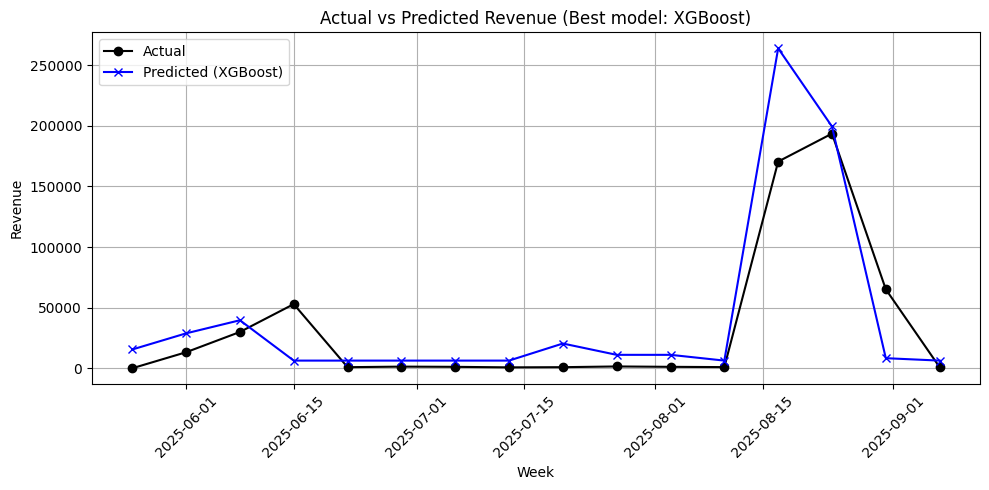

XGBoost RMSE on test set: 967055927.2266874


In [26]:
# find the model with lowest RMSE
best_model_name = comp_df.loc[comp_df['RMSE'].idxmin(), 'model']
print("Best model based on RMSE:", best_model_name)

#  map model name to predictions
pred_map = {
    'Ridge_rev': yhat_ridge,
    'Lasso_rev': yhat_lasso,
    'XGBoost': xgb_preds
}

best_preds = pred_map[best_model_name]

#  plot best model vs actual
plt.figure(figsize=(10,5))
plt.plot(test_weeks, y_test, label='Actual', marker='o', color='black')
plt.plot(test_weeks, best_preds, label=f'Predicted ({best_model_name})', marker='x', color='blue')
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.title(f'Actual vs Predicted Revenue (Best model: {best_model_name})')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#  print RMSE for the chosen model
best_rmse = mean_squared_error(y_test, best_preds)
print(f"{best_model_name} RMSE on test set:", best_rmse)
